In [1]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import linkage
import scipy.sparse as sp  # Import scipy.sparse as sp
from cellrank.estimators import GPCCA
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import scanpy.external as sce
import scrublet as scr
#import pyranges as pr
import seaborn as sns
import cellrank as cr
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import collections
import matplotlib
#import pyBigWig
#import networkx
#import pyscenic
import requests
#import network
#import fsspec
import anndata
#import igraph
import scvi
import h5py
import desc 
import umap
import sys
import re
import os


%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)
plt.rcParams.update({'font.size': 10})

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# Computing correlations for plain and perturb-seq samples

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
The following genes were not found in the combined data and will be skipped: {'INAFM2', 'MYL12B', 'TSKU-AS1', 'FKBP8', 'SMIM15', 'NFYB', 'RILPL2', 'RPS27A', 'ATP6V0D1', 'FAM218A', 'DLEU2', 'HNRNPDL', 'ING4', 'ITGB3BP', 'ARNT', 'NUDC

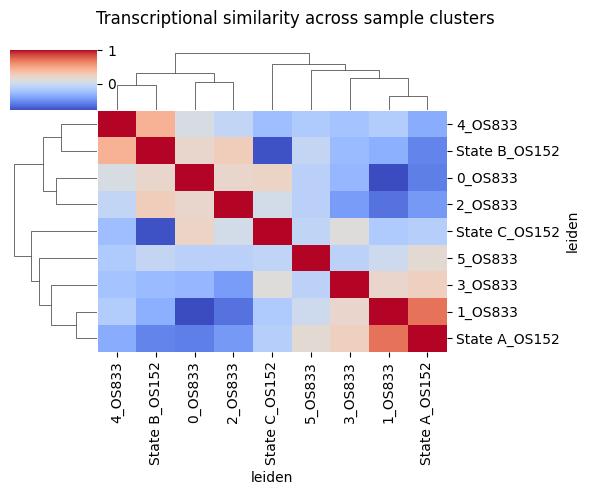

In [13]:
# Read in the AnnData files and process them
adata_list = []
top_genes_all_samples = []
sample_names_pert = ['OS833'] # ,,'OS833' ,'OS384','OS742'


for sample in sample_names_pert:
    
    # Read in the AnnData file
    adata = sc.read(f"/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/{sample}/{sample}_perturbseq_adata_leiden_PCA.h5ad")
    
    # Make cluster labels unique by combining 'leiden' and sample name
    adata.obs['leiden'] = adata.obs['leiden'].astype(str) + f'_{sample}'
    adata.obs['leiden'] = adata.obs['leiden'].astype('category')
    
    # Find top markers per cluster (leiden) in this sample
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=1000)
    
    # Extract the top X genes per cluster
    top_genes = []
    rg_names = adata.uns['rank_genes_groups']['names']
    
    
    for cluster in adata.obs['leiden'].cat.categories:
        genes = rg_names[cluster][:1000]
        top_genes.extend(genes)
    
    # Remove duplicates in the list of top genes for this sample
    top_genes = list(set(top_genes))
    
    # Append the top genes of this sample to the overall list
    top_genes_all_samples.extend(top_genes)
    
    # Add sample identifier
    adata.obs['sample'] = f"{sample}_pert"
    
    # Append the AnnData object to the list
    adata_list.append(adata)
    
    
sample_names = ['OS152'] #, 'OS152',,'OS384','OS742'


for sample in sample_names:
    
    # Read in the AnnData file
    adata = sc.read(f"/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/{sample}/{sample}_adata_subtype_PCA.h5ad")
    
    # creating a duplicate state column but renaming it to leiden
    adata.obs['leiden'] = adata.obs['State']
    
    
    # Make cluster labels unique by combining 'leiden' and sample name
    adata.obs['leiden'] = adata.obs['leiden'].astype(str) + f'_{sample}'
    adata.obs['leiden'] = adata.obs['leiden'].astype('category')
    
    # Find top markers per cluster (leiden) in this sample
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=1000)
    
    # Extract the top X genes per cluster
    top_genes = []
    rg_names = adata.uns['rank_genes_groups']['names']
    
    
    for cluster in adata.obs['leiden'].cat.categories:
        genes = rg_names[cluster][:1000]
        top_genes.extend(genes)
    
    # Remove duplicates in the list of top genes for this sample
    top_genes = list(set(top_genes))
    
    # Append the top genes of this sample to the overall list
    top_genes_all_samples.extend(top_genes)
    
    # Add sample identifier
    adata.obs['sample'] = sample
    
    # Append the AnnData object to the list
    adata_list.append(adata)

    
# Combine the top marker genes from all samples into a unique list
top_genes_all_samples = list(set(top_genes_all_samples))
top_genes_all_samples


# Concatenate the AnnData objects using join='outer' to include all genes
adata_combined = sc.AnnData.concatenate(
    *adata_list, batch_key='sample_batch', index_unique=None, join='outer'
)


# Ensure that 'leiden' is categorical in the combined data
adata_combined.obs['leiden'] = adata_combined.obs['leiden'].astype('category')


# Check if adata_combined.X is sparse
if sp.issparse(adata_combined.X):
    X_dense = adata_combined.X.toarray()
else:
    X_dense = adata_combined.X

    
# Identify genes with any NaN values across cells
genes_with_nan = np.isnan(X_dense).any(axis=0)


# Remove genes with NaN values
adata_combined = adata_combined[:, ~genes_with_nan]


# Refilter the markers based on whether they are in the dataset
existing_genes = [gene for gene in top_genes_all_samples if gene in adata_combined.var_names]


# Printing the missing genes
missing_genes = set(top_genes_all_samples) - set(existing_genes)
if missing_genes:
    print(f"The following genes were not found in the combined data and will be skipped: {missing_genes}")

    
# Continue with the existing genes
adata_markers = adata_combined[:, existing_genes]


# Compute the mean expression per cluster
cluster_means = adata_markers.to_df().groupby(adata_markers.obs['leiden']).mean()


# Normalize the data for better visualization (z-score normalization)
# Remove genes with zero variance to avoid division by zero
cluster_means = cluster_means.loc[:, cluster_means.std() > 0]
cluster_means_zscore = cluster_means.apply(lambda x: (x - x.mean()) / x.std(), axis=0)


# Compute the mean expression per cluster (assuming adata_markers is defined)
cluster_means = adata_markers.to_df().groupby(adata_markers.obs['leiden']).mean()


# Calculate the correlation matrix of cluster mean expressions
cluster_correlation = cluster_means.T.corr(method='pearson')


# Create a clustermap to visualize the correlations
g = sns.clustermap(cluster_correlation, cmap='coolwarm', figsize=(6, 5))


# Add the title to the figure
g.fig.suptitle('Transcriptional similarity across sample clusters', fontsize=12)


# Adjust the position of the title 
plt.subplots_adjust(top=0.9)


# Saving the figure
desktop_path = os.path.expanduser('~/Desktop')
figure_path = os.path.join(desktop_path, 'Pert_Cluster_Transcriptional_Similarity.svg')
g.savefig(figure_path, format='svg', dpi=300)


# Display the plot
plt.show()


# Defining states using correlation

In [14]:
# Identify perturb-seq clusters and plain clusters
pert_clusters = [cluster for cluster in cluster_correlation.index if 'State' not in cluster]
plain_clusters = [cluster for cluster in cluster_correlation.index if 'State'  in cluster]


# Subset the correlation matrix accordingly
pert_plain_corr = cluster_correlation.loc[pert_clusters, plain_clusters]


# For each perturb-seq cluster, find the plain cluster with highest correlation
results = []
for pert_cluster in pert_plain_corr.index:
    best_corr_cluster = pert_plain_corr.loc[pert_cluster].idxmax()
    best_corr_value = pert_plain_corr.loc[pert_cluster].max()
    
    # Use Pert_Cluster in your dictionary
    results.append({
        "Pert_Cluster": pert_cluster,  # Use pert_cluster here (not lt_cluster)
        "Highest_corr_Plain_Cluster": best_corr_cluster,
        "Correlation": best_corr_value
    })

    
# Now you can safely sort by "Pert_Cluster"
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Pert_Cluster").reset_index(drop=True)


results_df

,Pert_Cluster,Highest_corr_Plain_Cluster,Correlation
0,0_OS833,State C_OS152,0.218767
1,1_OS833,State A_OS152,0.707976
2,2_OS833,State B_OS152,0.264436
3,3_OS833,State A_OS152,0.249591
4,4_OS833,State B_OS152,0.439484
5,5_OS833,State A_OS152,0.157095
